In [37]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy import units as u
from tools import *

In [62]:
grid = np.loadtxt('../../data/sn/yossef/output.flx_luminos')
t = np.loadtxt('../../data/sn/yossef/time_s.txt')
wave = np.loadtxt('../../data/sn/yossef/wave.txt') * 10**8 # angst

dist = 10*u.pc
dist = dist.to(u.cm)
grid = grid/(4*np.pi*dist.value**2) #/ wave[np.newaxis,:]

In [69]:
4*np.pi*dist.value**2

1.1964951828635063e+40

<IPython.core.display.Javascript object>


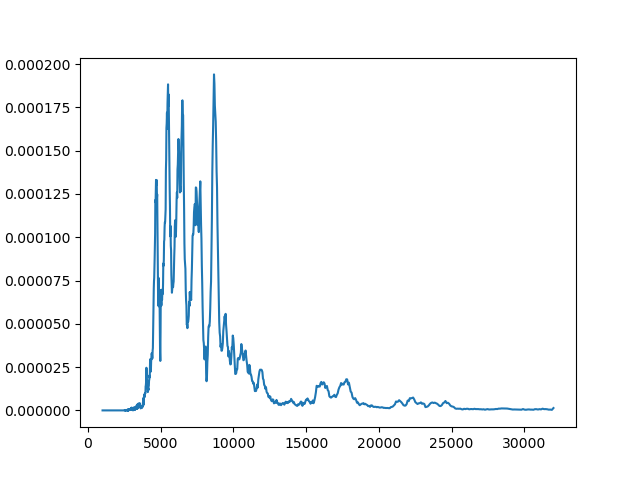

In [40]:
plt.figure()
plt.plot(wave,grid[90]);

In [63]:
spec = []
for i in range(grid.shape[0]):
    spec += [S.ArraySpectrum(wave=wave,flux=grid[i])]

In [46]:
passbands = at.Table.read('source_synphot/passbands/pbzptmag.txt',format='ascii')
pbnames = [x['obsmode'] for x in passbands if x['passband'].startswith("Kep")]
pbnames += [x['obsmode'] for x in passbands if x['passband'].startswith("PS1")]
pbnames += [x['obsmode'] for x in passbands if x['passband'].startswith("Bessell/")]
model_mags = 0.
model = 'AB'
pbs = source_synphot.passband.load_pbs(pbnames, model_mags, model)
pbnames = pbs.keys()

In [47]:
pbnames

odict_keys(['Kep', 'ps1g', 'ps1r', 'ps1i', 'ps1z', 'ps1y', 'besU', 'besB', 'besV', 'besR', 'besI'])

In [56]:


def Specs(Specs):
    specs = {}
    for spec in Specs:
        print(spec)
        model_sed = source_synphot.source.pre_process_source(spec,np.nan,'ps1g',0,Renorm=False)
        specs[spec] = model_sed

    return specs

def Spec_mags(Models,pbs,ex=0,Conversion = 1.029):
    """
    Generate synthetic magnitudes from the models and passbands added.
    Conversion converts between Ebv and Egr, the Green value is 0.981, but the best fit value
    was found to be 1.029.
    """
    print('lego')
    a_v = 3.1*(Conversion * ex ) # ex = extinction from Bayestar19 = Egr
    keys = list(pbs.keys())
    mags = {}
    for key in keys:
        mags[key] = []
    
        pb, zp = pbs[key]
    
        # construct mags
        ind = []
        red = {}
        for model in Models:
            mags[key] += [source_synphot.passband.synphot(model, pb,zp)]

    for key in keys:
        mags[key] = np.array(mags[key])
        
    good = np.ones(len(mags[key])) > 0
    for key in keys:
        good = good *np.isfinite(mags[key])
    for key in keys:
        mags[key] = mags[key][good]
    return mags

def my_norm(Spec,pbs,mag):
    spec = deepcopy(Spec)
    m = Syn_mag(pbs,spec)
    m=m['besI']
    print(mag-m)
    factor = 10**(-2/5*(mag-m))
    spec = S.ArraySpectrum(wave=spec.wave,waveunits=spec.waveunits,
                                   flux=spec.flux*factor,fluxunits=spec.fluxunits)
    return spec

def Syn_mag(pbs,spec):
    mag = {}
    for pb in pbs:
        if spec is not None:
            syn_mag = source_synphot.passband.synphot(spec,pbs[pb][0],zp=pbs[pb][1])
        else:
            syn_mag = np.nan
        mag[pb] = syn_mag
        
    return mag

In [65]:
mags = Spec_mags(spec,pbs)

lego


In [66]:
mags.keys()

dict_keys(['Kep', 'ps1g', 'ps1r', 'ps1i', 'ps1z', 'ps1y', 'besU', 'besB', 'besV', 'besR', 'besI'])

<IPython.core.display.Javascript object>


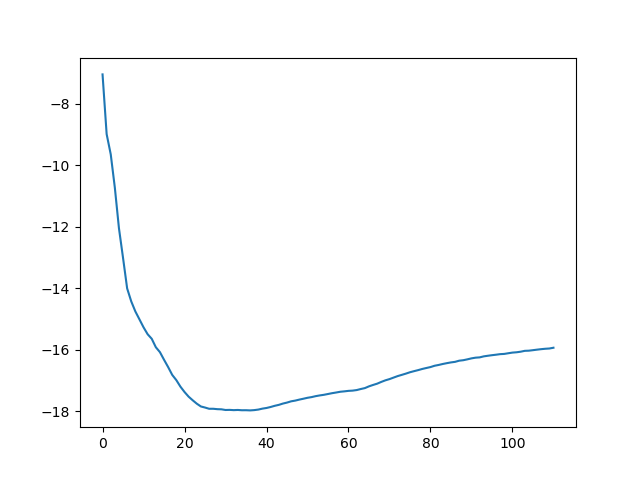

In [68]:
plt.figure()
plt.plot(mags['ps1r']+4.7)

In [ ]:
'/Users/rridden/Documents/work/code/source_synphot/source_synphot/'